# Importo y defino

In [15]:
import numpy as np
import openmc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def tally_flux_2_df(path, tally_name, corriente):
    sp = openmc.StatePoint(path)
    tally = sp.get_tally(name=tally_name)
    df = tally.get_pandas_dataframe()
    if len(df.columns) == 7:
        df.columns = [
            "x",
            "y",
            "z",
            "nuclide",
            "score",
            "mean",
            "std.dev.",
        ]
    else:
        df.columns = [
            "x",
            "y",
            "z",
            "nuclide",
            "score",
            "mean",
        ]
        df["std.dev."] = 1000

    volumen_celda = (
        tally.filters[0]._mesh.total_volume / tally.filters[0]._mesh.num_mesh_cells
    )
    df["mean_norm"] = df["mean"] / volumen_celda * corriente
    df["std.dev._norm"] = df["std.dev."] / volumen_celda
    z_min = tally.filters[0]._mesh.lower_left[2]
    z_max = tally.filters[0]._mesh.upper_right[2]
    z = np.linspace(z_min, z_max, tally.filters[0]._mesh.num_mesh_cells + 1)
    z_midpoints = (z[:-1] + z[1:]) / 2
    df["z_midpoints"] = z_midpoints
    return df


def get_tally_agua(df_total, df_vacio):
    volumen_total = df_total["mean"].sum() / df_total["mean_norm"].sum()
    volumen_vacio = df_vacio["mean"].sum() / df_vacio["mean_norm"].sum()
    volumen_agua = volumen_total - volumen_vacio

    df_agua = df_total.copy()
    df_agua["mean"] = df_agua["mean"] - df_vacio["mean"]
    df_agua["std.dev."] = np.sqrt(
        df_agua["std.dev."] ** 2 + df_vacio["std.dev."] ** 2
    )  # Revisar esto si hace falta. No se reviso hasta el momento.
    df_agua["mean_norm"] = df_agua["mean"] / volumen_agua
    df_agua["std.dev._norm"] = df_agua["std.dev."] / volumen_agua

    return df_agua


def plot_flux(df_flux_total, df_flux_vacio, df_flux_agua, save=False):
    plt.figure(figsize=(10, 6))
    plt.plot(
        df_flux_agua["z_midpoints"],
        df_flux_agua["mean_norm"],
        label="Flujo en agua",
        color="blue",
    )
    plt.plot(
        df_flux_vacio["z_midpoints"],
        df_flux_vacio["mean_norm"],
        label="Flujo en vacío",
        color="red",
    )
    plt.plot(
        df_flux_total["z_midpoints"],
        df_flux_total["mean_norm"],
        label="Flujo total",
        color="green",
    )
    plt.xlabel("z [cm]")
    plt.ylabel("Flujo [cm$^{-2}$ s$^{-1}$]")
    plt.title("Flujo en funcion de z")
    plt.legend()
    plt.grid()
    plt.yscale("log")
    if save:
        plt.savefig(
            "flujos1.png",
            bbox_inches="tight",
            dpi=600,
        )
    plt.show()


def plot_flux_comparison(
    df_total_orig,
    df_total_sint,
    df_vacio_orig,
    df_vacio_sint,
    df_agua_orig,
    df_agua_sint,
    z0: float,
    factor=1.0,
    save=True,
    zmin=None,
    zmax=None,
) -> None:
    """
    Compara gráficamente el flujo entre simulaciones original y sintética para las regiones:
    total, agua y vacío, e incluye errores relativos (en %), interpolando sobre un eje z común.

    El dominio va desde z0_sint hasta el mínimo z_max de ambas curvas.
    """

    def compute_relative_error(
        df_orig, df_sint, factor: float = 1.0
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Calcula el error relativo (%) entre los perfiles original y sintético de flujo
        usando exclusivamente las coordenadas z del dataset sintético.

        Parámetros
        ----------
        df_orig : DataFrame
            Debe contener columnas 'z_midpoints' y 'mean_norm' del perfil original.
        df_sint : DataFrame
            Debe contener columnas 'z_midpoints' y 'mean_norm' del perfil sintético.
        factor : float, opcional
            Factor de escala a aplicar al perfil sintético antes de la comparación.

        Retorna
        -------
        z_sint : ndarray
            Los valores de z donde se evalúa el error (los z_midpoints de df_sint).
        err_rel : ndarray
            El error relativo en %, con np.nan donde el original es cero
            y np.inf donde la interpolación original da exactamente cero.
        """
        # 1) Usamos los z del sintético
        z_sint = df_sint["z_midpoints"].values

        # 2) Interpolamos el original en esos mismos z
        interp_orig = np.interp(
            z_sint,
            df_orig["z_midpoints"].values,
            df_orig["mean_norm"].values,
        )

        # 3) Obtenemos el sintético escalado
        interp_sint = df_sint["mean_norm"].values * factor

        # 4) Máscara de valores donde el original no es cero
        mask_nonzero = interp_orig != 0

        # 5) Inicializamos con NaN
        err_rel = np.full_like(interp_orig, fill_value=np.nan, dtype=float)

        # 6) Calcular % de error relativo
        err_rel[mask_nonzero] = (
            100
            * (interp_orig[mask_nonzero] - interp_sint[mask_nonzero])
            / interp_orig[mask_nonzero]
        )

        # 7) Si el original es cero, dejamos infinito
        err_rel[~mask_nonzero] = np.inf

        # plt.figure(figsize=(5, 3))
        # plt.plot(z_sint, df_sint["mean_norm"] * factor, label="Sintético", color="red", marker="x")
        # plt.plot(
        #     z_sint,
        #     interp_orig,
        #     label="Original (Interpolado)",
        #     color="blue",
        #     linestyle="--",
        #     marker="o",
        # )
        # plt.plot(
        #     df_orig["z_midpoints"],
        #     df_orig["mean_norm"],
        #     label="Original (Real)",
        #     color="green",
        #     linestyle=":",
        #     marker="s",
        # )
        # # plt.yscale("log")
        # plt.show()

        return z_sint, err_rel

    def redondear_a_una_cifra(x: float) -> float:
        """
        Redondea un número positivo a una sola cifra significativa.
        Por ejemplo:
        - 3.76 → 4
        - 0.084 → 0.08
        - 123 → 100
        """
        if x == 0:
            return 0
        exponente = np.floor(np.log10(abs(x)))
        return round(x / 10**exponente) * 10**exponente

    fig = plt.figure(figsize=(16 * 1.25, 9 * 0.8))
    gs = gridspec.GridSpec(2, 3, height_ratios=[2.5, 1])
    axs = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(3)]

    plt.subplots_adjust(
        left=0.07, right=0.95, top=0.94, bottom=0.07, wspace=0.3, hspace=0.25
    )

    nombres = ["Total", "Agua", "Vacío"]
    df_orig_all = [df_total_orig, df_agua_orig, df_vacio_orig]
    df_sint_all = [df_total_sint, df_agua_sint, df_vacio_sint]

    for i in range(3):
        df_orig = df_orig_all[i]
        df_sint = df_sint_all[i]

        # Establecer límites comunes en eje x
        z_min = 0
        z_max = min(df_orig["z_midpoints"].max(), df_sint["z_midpoints"].max())
        z_min = z_min - (z_max - z_min) * 0.05
        z_max = z_max + (z_max - z_min) * 0.05

        # Curvas originales y sintéticas
        axs[i].plot(
            df_orig["z_midpoints"],
            df_orig["mean_norm"],
            label="Simulación fuente original",
            color="blue",
            linestyle="--",
            marker="o",
        )
        axs[i].plot(
            df_sint["z_midpoints"],
            df_sint["mean_norm"] * factor,
            label="Simulación fuente distribucional",
            color="red",
            linestyle="-",
            marker="x",
        )
        axs[i].set_title(f"Flujo {nombres[i]} vs. z")
        axs[i].set_ylabel(r"$\frac{\phi}{S_0}$ [cm$^{-2}$]", fontsize=12)
        axs[i].set_yscale("log")
        # axs[i].set_xlabel("z [cm]")
        axs[i].grid(True, which="both", linestyle="--", linewidth=0.5)
        axs[i].legend()
        axs[i].set_xlim(z_min, z_max)  # sincronizar eje x
        if zmin is not None:
            axs[i].set_xlim(left=zmin)
        if zmax is not None:
            axs[i].set_xlim(right=zmax)

        # Error relativo interpolado
        z_interp, err_rel = compute_relative_error(df_orig, df_sint, factor=factor)
        axs[i + 3].plot(z_interp, err_rel, color="black")
        axs[i + 3].axhline(0, color="gray", linestyle="--", linewidth=1)
        axs[i + 3].set_ylabel("Error relativo [%]",fontsize=12)
        axs[i + 3].set_xlabel("z [cm]")

        # Cálculo de límites del eje y con margen simétrico (rango total)
        err_min = np.nanmin(err_rel)
        err_max = np.nanmax(err_rel)
        y_range = err_max - err_min
        y_margin = y_range * 0.05

        y_lim_min = max(err_min - y_margin, -100)
        y_lim_max = min(err_max + y_margin, 100)
        axs[i + 3].set_ylim(y_lim_min, y_lim_max)

        # Calcular paso = 20% del rango, redondeado a 1 cifra significativa
        paso_base = 0.2 * (y_lim_max - y_lim_min)

        # Redondear a 1 cifra significativa
        paso = max(redondear_a_una_cifra(paso_base), 1e-6)

        # Establecer ticks manuales
        ticks_y = np.arange(np.floor(y_lim_min), np.ceil(y_lim_max) + paso, paso)

        # Asegurarse de que 0 esté en los ticks
        if not np.any(np.isclose(ticks_y, 0)):
            ticks_y = np.sort(np.append(ticks_y, 0.0))

        if len(ticks_y) > 10:
            # Si hay demasiados ticks, reducirlos a un máximo de 10
            ticks_y = np.linspace(ticks_y[0], ticks_y[-1], 10)

        axs[i + 3].set_yticks(ticks_y)

        axs[i + 3].grid(True, which="both", linestyle="--", linewidth=0.5)
        axs[i + 3].set_xlim(z_min, z_max)  # sincronizar eje x
        if zmin is not None:
            axs[i + 3].set_xlim(left=zmin)
        if zmax is not None:
            axs[i + 3].set_xlim(right=zmax)

    if save:
        plt.savefig("comparacion_flujos.png", bbox_inches="tight", dpi=600)
    plt.show()


def combinar_statepoints(sp_list, sp_N_list, tally_name="detector_neutron"):
    dfs = []
    for sp_path, n_batches in zip(sp_list, sp_N_list):
        with openmc.StatePoint(sp_path) as sp:
            tally = sp.get_tally(name=tally_name)
            df = tally.get_pandas_dataframe(nuclides=False)
            df = df[
                [
                    "energy low [eV]",
                    "energy high [eV]",
                    "cell",
                    "particle",
                    "score",
                    "mean",
                    "std. dev.",
                ]
            ].copy()
            df.columns = ["Emin", "Emax", "cell", "particle", "score", "mean", "stdv"]
            df["mean"] *= n_batches
            df["stdv2"] = (df["stdv"] ** 2) * n_batches
            dfs.append(df)

    # Sumar todos los dataframes
    df_sum = dfs[0][["Emin", "Emax", "cell", "particle", "score"]].copy()
    df_sum["mean"] = 0
    df_sum["stdv2"] = 0

    for df in dfs:
        df_sum["mean"] += df["mean"]
        df_sum["stdv2"] += df["stdv2"]

    total_batches = sum(sp_N_list)
    df_sum["mean"] /= total_batches
    df_sum["stdv"] = np.sqrt(df_sum["stdv2"] / total_batches)
    df_sum = df_sum.drop(columns=["stdv2"])

    return df_sum


from typing import List, Tuple


def combinar_statepoints_flux(
    sp_paths: List[str], sp_N: List[float], tally_names=("flux_total", "flux_vacio")
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Combina los resultados de múltiples statepoints para obtener los flujos
    promediados en agua, vacío y total, ponderando por la cantidad de partículas.

    Parameters
    ----------
    sp_paths : list of str
        Paths a los archivos .h5 de cada statepoint.
    sp_N : list of float
        Número de partículas simuladas en cada archivo.
    tally_names : tuple of str
        Nombres de los tallies para el flujo total y en vacío.
        El flujo en agua se calcula por diferencia.

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        DataFrames combinados para flujo total, vacío y agua.
    """
    dfs_total = []
    dfs_vacio = []

    for path, N in zip(sp_paths, sp_N):
        df_total = tally_flux_2_df(path, tally_names[0], corriente=1.0)
        df_vacio = tally_flux_2_df(path, tally_names[1], corriente=1.0)
        df_total["N"] = N
        df_vacio["N"] = N
        dfs_total.append(df_total)
        dfs_vacio.append(df_vacio)

    def combinar_df_flux(dfs: List[pd.DataFrame]) -> pd.DataFrame:
        """Promedia múltiples DF de flujo ponderando por N y propaga el error."""
        base = dfs[0][["z_midpoints"]].copy()
        base["mean"] = 0.0
        base["std.dev."] = 0.0
        base["mean_norm"] = 0.0
        base["std.dev._norm"] = 0.0
        total_N = 0.0

        for df in dfs:
            N = df["N"].iloc[0]
            base["mean"] += df["mean"] * N
            base["std.dev."] += (df["std.dev."] ** 2) * N
            base["mean_norm"] += df["mean_norm"] * N
            base["std.dev._norm"] += (df["std.dev._norm"] ** 2) * N
            total_N += N

        base["mean"] /= total_N
        base["std.dev."] = (base["std.dev."] / total_N) ** 0.5
        base["mean_norm"] /= total_N
        base["std.dev._norm"] = (base["std.dev._norm"] / total_N) ** 0.5
        return base

    df_total_comb = combinar_df_flux(dfs_total)
    df_vacio_comb = combinar_df_flux(dfs_vacio)

    # Flujo en agua = total - vacío, con propagación de error
    df_agua_comb = get_tally_agua(df_total_comb, df_vacio_comb)

    return df_total_comb, df_vacio_comb, df_agua_comb

# statepoint original

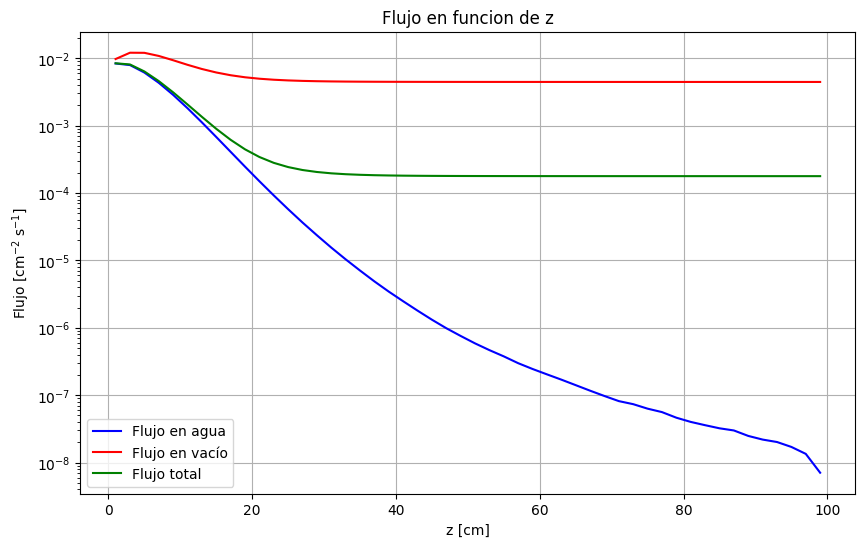

In [2]:
sp = []
sp_N = [] # Cantidad de particulas de cada statepoint

# Corrida 4
sp1 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida4/statepoint.1000.h5"
sp.append(sp1)
sp1_N = 1e6 
sp_N.append(sp1_N)

# Corrida 5
sp2 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida5/statepoint.1000.h5"
sp.append(sp2)
sp2_N = 1e6 
sp_N.append(sp2_N)

# Corrida 6
sp3 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida6/statepoint.1000.h5"
sp.append(sp3)
sp3_N = 1e6 
sp_N.append(sp3_N)

# Corrida 7
sp4 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida7/sim1/statepoint.1000.h5"
sp.append(sp4)
sp4_N = 1e6
sp_N.append(sp4_N)

sp5 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida7/sim2/statepoint.1000.h5"
sp.append(sp5)
sp5_N = 1e6
sp_N.append(sp5_N)

sp6 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida7/sim3/statepoint.1000.h5"
sp.append(sp6)
sp6_N = 1e6
sp_N.append(sp6_N)

sp7 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida7/sim4/statepoint.1000.h5"
sp.append(sp7)
sp7_N = 1e6
sp_N.append(sp7_N)

# Corrida 8
sp8 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida8/sim1/statepoint.1000.h5"
sp.append(sp8)
sp8_N = 1e6
sp_N.append(sp8_N)

sp9 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida8/sim2/statepoint.1000.h5"
sp.append(sp9)
sp9_N = 1e6
sp_N.append(sp9_N)

sp10 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida8/sim3/statepoint.1000.h5"
sp.append(sp10)
sp10_N = 1e6
sp_N.append(sp10_N)

sp11 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida8/sim4/statepoint.1000.h5"
sp.append(sp11)
sp11_N = 1e6
sp_N.append(sp11_N)

# corrida 9
sp12 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida9/sim1/statepoint.1000.h5"
sp.append(sp12)
sp12_N = 1e6
sp_N.append(sp12_N) 

sp13 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida9/sim2/statepoint.1000.h5"
sp.append(sp13)
sp13_N = 1e6
sp_N.append(sp13_N)

sp14 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida9/sim3/statepoint.1000.h5"
sp.append(sp14)
sp14_N = 1e6
sp_N.append(sp14_N)

sp15 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida9/sim4/statepoint.1000.h5"
sp.append(sp15)
sp15_N = 1e6
sp_N.append(sp15_N)

sp16 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida9/sim5/statepoint.1000.h5"
sp.append(sp16)
sp16_N = 1e6
sp_N.append(sp16_N)

sp17 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida9/sim6/statepoint.1000.h5"
sp.append(sp17)
sp17_N = 1e6
sp_N.append(sp17_N)

sp18 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida9/sim7/statepoint.1000.h5"
sp.append(sp18)
sp18_N = 1e6
sp_N.append(sp18_N)

# corrida 10
sp19 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida10/sim1/statepoint.1000.h5"
sp.append(sp19)
sp19_N = 1e6
sp_N.append(sp19_N)

sp20 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida10/sim2/statepoint.1000.h5"
sp.append(sp20)
sp20_N = 1e6
sp_N.append(sp20_N)

sp21 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida10/sim3/statepoint.1000.h5"
sp.append(sp21)
sp21_N = 1e6
sp_N.append(sp21_N)

sp22 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida10/sim4/statepoint.1000.h5"
sp.append(sp22)
sp22_N = 1e6
sp_N.append(sp22_N)

sp23 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida10/sim5/statepoint.1000.h5"
sp.append(sp23)
sp23_N = 1e6
sp_N.append(sp23_N)

# corrida 11: agregamos sims 1 a 9
for i in range(1, 10):
    sp_path = f"/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida11/sim{i}/statepoint.1000.h5"
    sp.append(sp_path)
    sp_N.append(1e6)


df_total, df_vacio, df_agua = combinar_statepoints_flux(sp, sp_N)

# plot_flux(
#     df_total,
#     df_vacio,
#     df_agua,
#     save=False,
# )

sp_corrida15 = []
N_corrida15 = [] # Cantidad de particulas de cada statepoint

# simulacion 1-15
for i in range(1, 16):
    sp_corrida15.append(f"/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida15/sim{i}/statepoint.1000.h5")
    N_corrida15.append(1e6)

# simulacion 16-18
for i in range(16, 19):
    sp_corrida15.append(f"/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida15/sim{i}/statepoint.1000.h5")
    N_corrida15.append(5e6)


df_total_corrida15, df_vacio_corrida15, df_agua_corrida15 = combinar_statepoints_flux(sp_corrida15, N_corrida15)

sp_corrida16 = []
N_corrida16 = [] # Cantidad de particulas de cada statepoint

# simulacion 1
sp_corrida16.append(f"/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida16/statepoint.14000.h5")
N_corrida16.append(14000*5000)

df_total_corrida16, df_vacio_corrida16, df_agua_corrida16 = combinar_statepoints_flux(sp_corrida16, N_corrida16)

plot_flux(
    df_total_corrida16,
    df_vacio_corrida16,
    df_agua_corrida16,
    save=False,
)


# Corrida 12

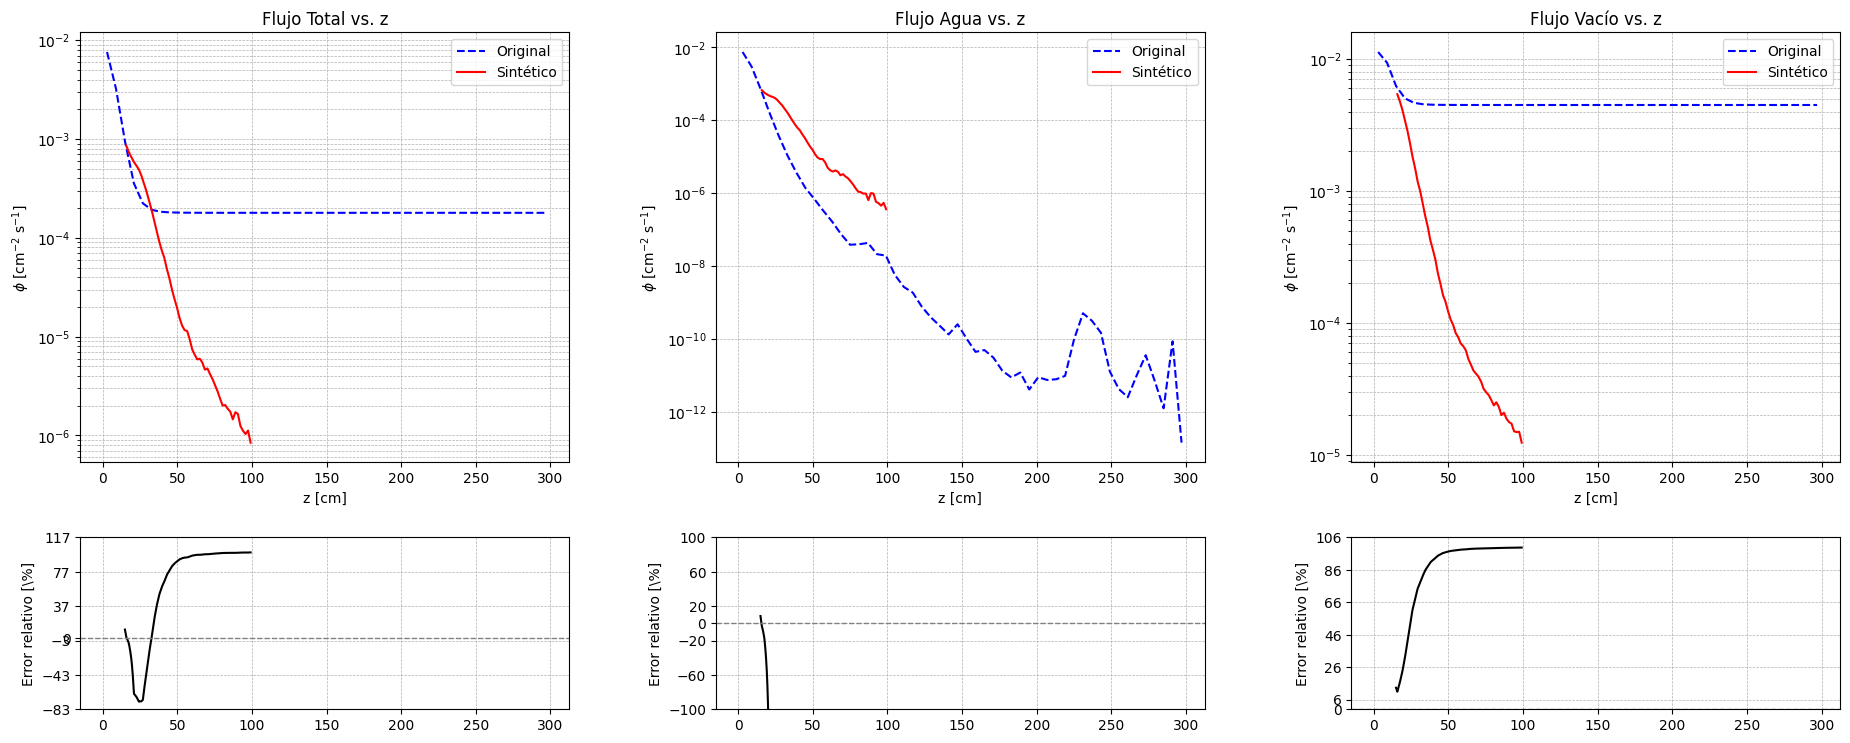

In [3]:
sp_corrida12 = []
N_corrida12 = [] # Cantidad de particulas de cada statepoint

# simulacion 1
sp_corrida12.append("/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida12/sim1/statepoint.1000.h5")
N_corrida12.append(1e4)

# # simulacion 2-3
# for i in range(2, 4):
#     sp_corrida12.append(f"/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida12/sim{i}/statepoint.1000.h5")
#     N_corrida12.append(1e6)


df_total_corrida12, df_vacio_corrida12, df_agua_corrida12 = combinar_statepoints_flux(sp_corrida12, N_corrida12)

plot_flux_comparison(
    df_total_orig=df_total,
    df_total_sint=df_total_corrida12,
    df_vacio_orig=df_vacio,
    df_vacio_sint=df_vacio_corrida12,
    df_agua_orig=df_agua,
    df_agua_sint=df_agua_corrida12,
    z0=15,
    save=False,
)



# Corrida 13

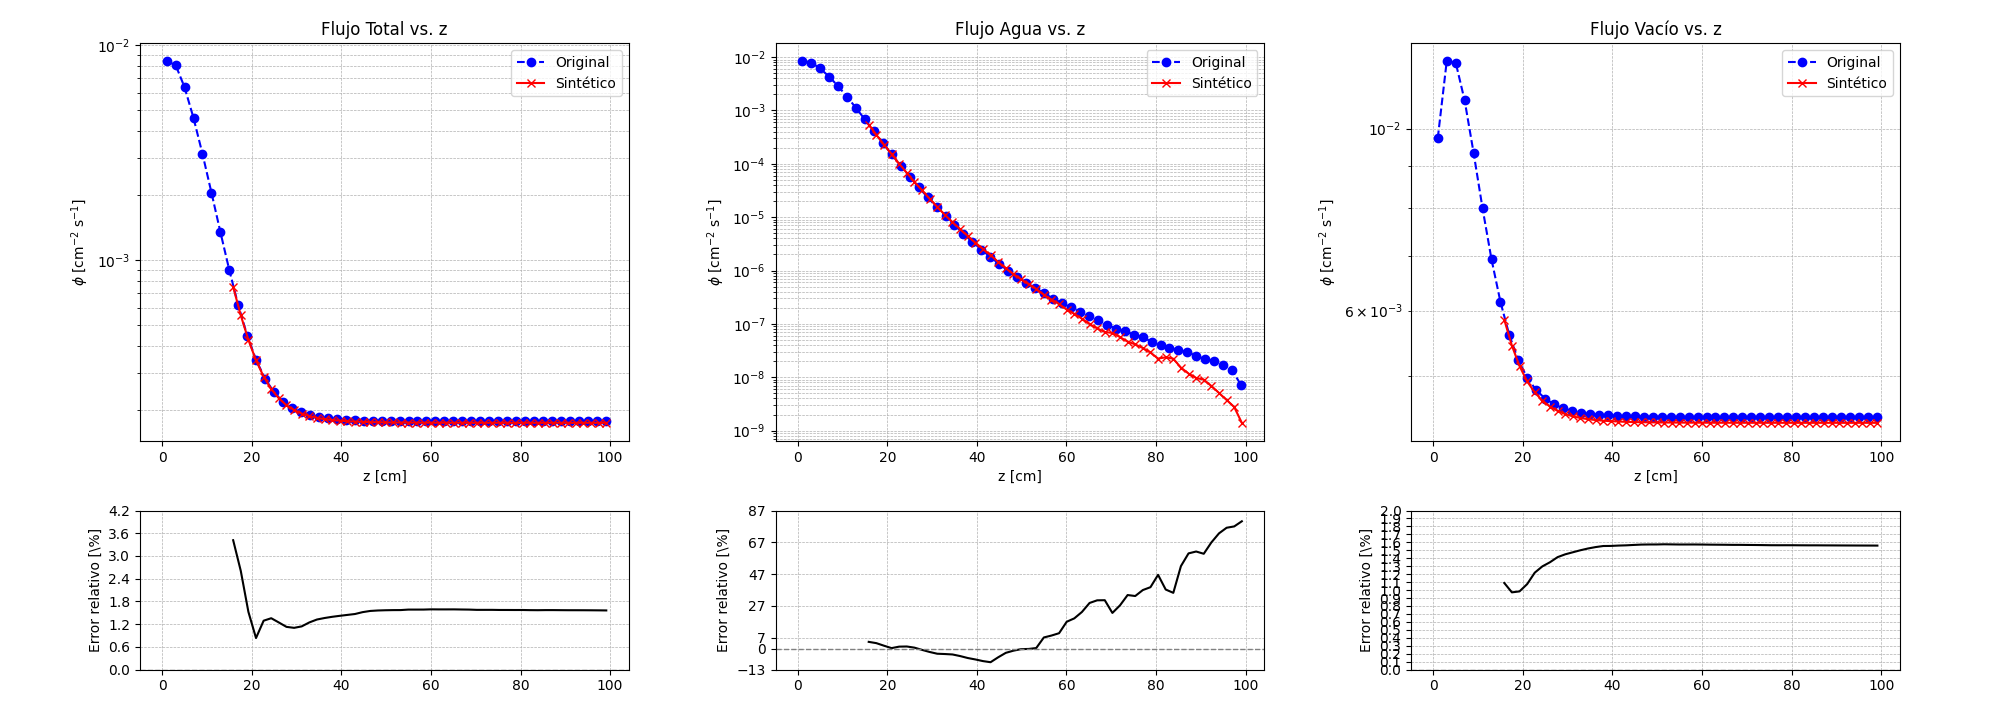

In [3]:
sp_corrida13 = []
N_corrida13 = [] # Cantidad de particulas de cada statepoint

# simulacion 1
sp_corrida13.append("/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida13/sim1/statepoint.1000.h5")
N_corrida13.append(1e4)

# simulacion 2-3
for i in range(2, 4):
    sp_corrida13.append(f"/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida13/sim{i}/statepoint.1000.h5")
    N_corrida13.append(1e4)

# simulacion 4-5
for i in range(4, 6):
    sp_corrida13.append(f"/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida13/sim{i}/statepoint.1000.h5")
    N_corrida13.append(1e6)


df_total_corrida13, df_vacio_corrida13, df_agua_corrida13 = combinar_statepoints_flux(sp_corrida13, N_corrida13)

%matplotlib widget

plot_flux_comparison(
    df_total_orig=df_total_corrida16,
    df_total_sint=df_total_corrida13,
    df_vacio_orig=df_vacio_corrida16,
    df_vacio_sint=df_vacio_corrida13,
    df_agua_orig=df_agua_corrida16,
    df_agua_sint=df_agua_corrida13,
    z0=15,
    save=False,
    # factor=1.023,
    # zmin=15,
    # zmax=30,
)



# Corrida 14

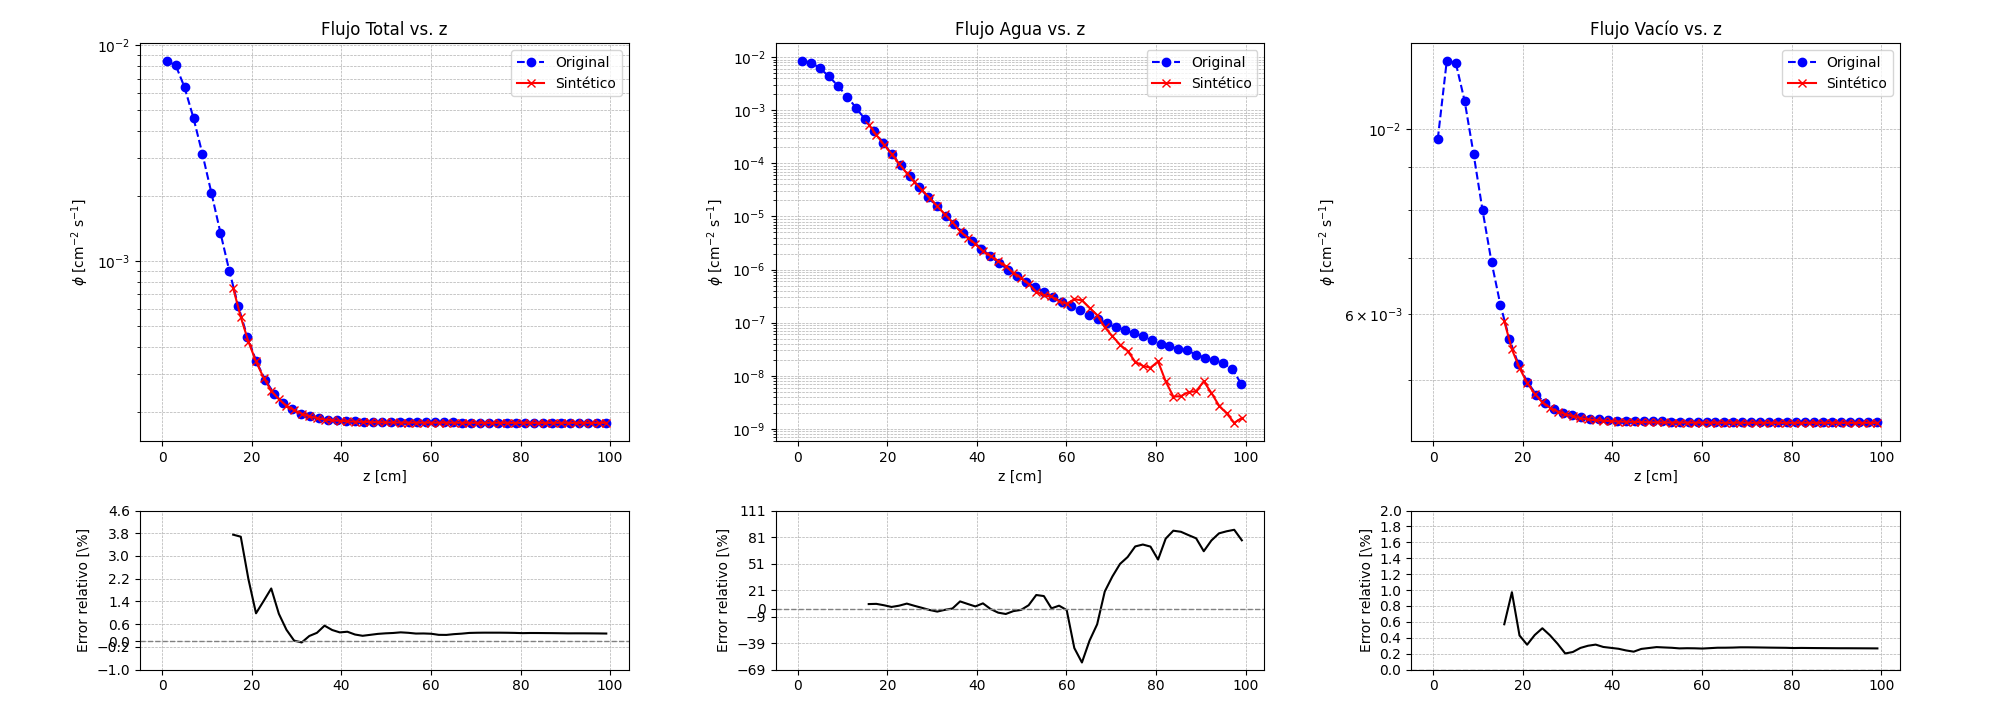

In [4]:
sp_corrida14 = []
N_corrida14 = [] # Cantidad de particulas de cada statepoint

# # simulacion 1
# sp_corrida14.append("/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida14/sim1/statepoint.1000.h5")
# N_corrida14.append(1e4)

# simulacion 1-10
for i in range(1, 11):
    sp_corrida14.append(f"/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida14/sim{i}/statepoint.1000.h5")
    N_corrida14.append(1e4)


df_total_corrida14, df_vacio_corrida14, df_agua_corrida14 = combinar_statepoints_flux(sp_corrida14, N_corrida14)



plot_flux_comparison(
    df_total_orig=df_total_corrida16,
    df_total_sint=df_total_corrida14,
    df_vacio_orig=df_vacio_corrida16,
    df_vacio_sint=df_vacio_corrida14,
    df_agua_orig=df_agua_corrida16,
    df_agua_sint=df_agua_corrida14,
    z0=15,
    save=False,
    factor=0.9878,
)



# Corrida 17


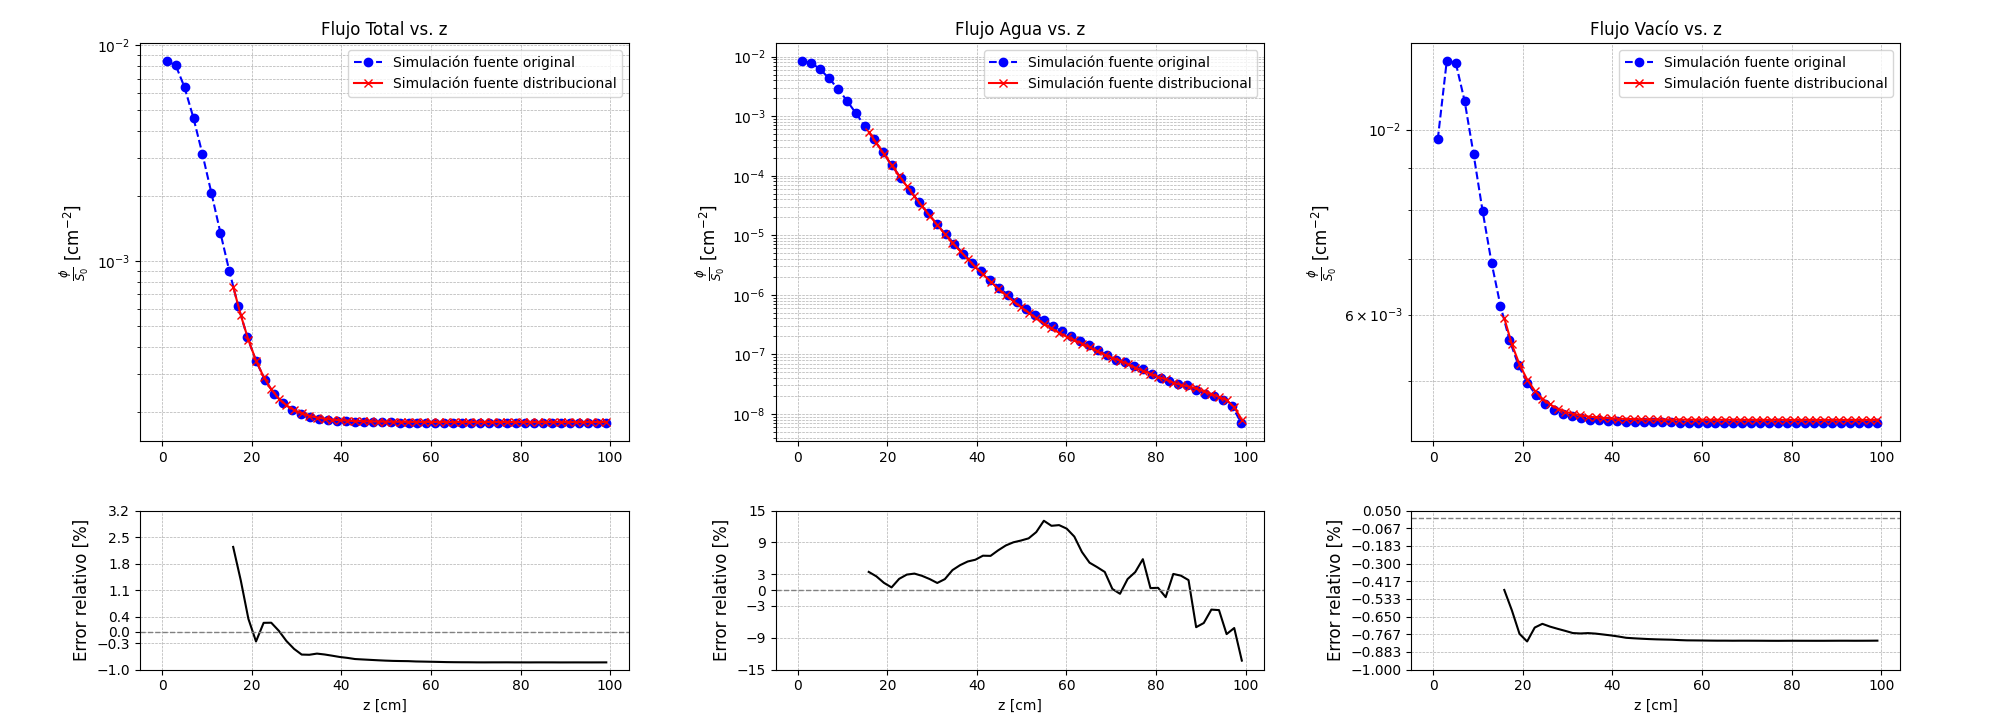

In [16]:
sp_corrida17 = []
N_corrida17 = [] # Cantidad de particulas de cada statepoint

# # simulacion 1
sp_corrida17.append("/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida17/statepoint.9500.h5")
N_corrida17.append(1e4)

df_total_corrida17, df_vacio_corrida17, df_agua_corrida17 = combinar_statepoints_flux(sp_corrida17, N_corrida17)


%matplotlib widget
plot_flux_comparison(
    df_total_orig=df_total_corrida16,
    df_total_sint=df_total_corrida17,
    df_vacio_orig=df_vacio_corrida16,
    df_vacio_sint=df_vacio_corrida17,
    df_agua_orig=df_agua_corrida16,
    df_agua_sint=df_agua_corrida17,
    z0=15,
    save=False,
    # factor=0.992,
    # zmin=50,
    # zmax=50,
)

# Corrida 18


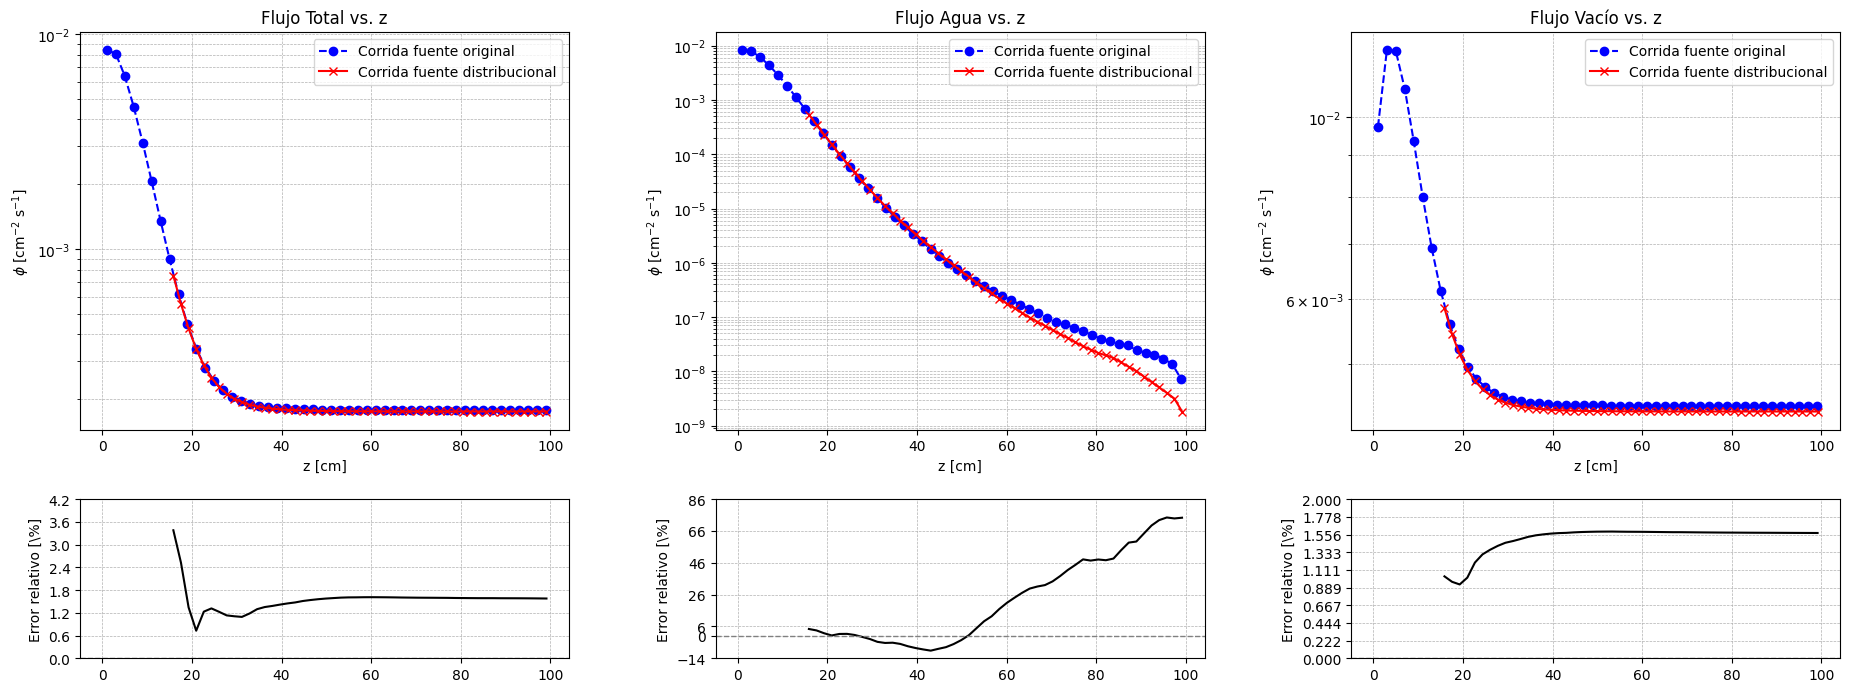

In [7]:
sp_corrida17 = []
N_corrida17 = [] # Cantidad de particulas de cada statepoint

# # simulacion 1
sp_corrida17.append("/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida18/statepoint.7500.h5")
N_corrida17.append(1e4)

df_total_corrida17, df_vacio_corrida17, df_agua_corrida17 = combinar_statepoints_flux(sp_corrida17, N_corrida17)


# %matplotlib widget
plot_flux_comparison(
    df_total_orig=df_total_corrida16,
    df_total_sint=df_total_corrida17,
    df_vacio_orig=df_vacio_corrida16,
    df_vacio_sint=df_vacio_corrida17,
    df_agua_orig=df_agua_corrida16,
    df_agua_sint=df_agua_corrida17,
    z0=15,
    save=False,
    # factor=1.016,
    # zmin=50,
    # zmax=50,
)

In [3]:
# # corrida4
# path_corrida4 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida4/statepoint.1000.h5"
# corriente_corrida4 = 1.0

# df_corrida4_total = tally_flux_2_df(path_corrida4, "flux_total", corriente_corrida4)
# df_corrida4_vacio = tally_flux_2_df(path_corrida4, "flux_vacio", corriente_corrida4)
# df_corrida4_agua = get_tally_agua(
#     df_corrida4_total, df_corrida4_vacio
# )  # Flujo en agua

# # corrida5
# path_corrida5 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida5/statepoint.1000.h5"
# corriente_corrida5 = 1.0
# df_corrida5_total = tally_flux_2_df(path_corrida5, "flux_total", corriente_corrida5)
# df_corrida5_vacio = tally_flux_2_df(path_corrida5, "flux_vacio", corriente_corrida5)
# df_corrida5_agua = get_tally_agua(
#     df_corrida5_total, df_corrida5_vacio
# )  # Flujo en agua

# # corrida6
# path_corrida6 = "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida6/statepoint.1000.h5"
# corriente_corrida6 = 1.0
# df_corrida6_total = tally_flux_2_df(path_corrida6, "flux_total", corriente_corrida6)
# df_corrida6_vacio = tally_flux_2_df(path_corrida6, "flux_vacio", corriente_corrida6)
# df_corrida6_agua = get_tally_agua(
#     df_corrida6_total, df_corrida6_vacio
# )

# # plot_flux_comparison(
# #     df_corrida4_total,
# #     df_corrida5_total,
# #     df_corrida4_vacio,
# #     df_corrida5_vacio,
# #     df_corrida4_agua,
# #     df_corrida5_agua,
# #     z0=0.0,
# #     save=False,
# # )

# plot_flux_comparison(
#     df_corrida4_total,
#     df_total,
#     df_corrida4_vacio,
#     df_vacio,
#     df_corrida4_agua,
#     df_agua,
#     z0=0.0,
#     save=False,
# )

# plot_flux_comparison(
#     df_corrida5_total,
#     df_total,
#     df_corrida5_vacio,
#     df_vacio,
#     df_corrida5_agua,
#     df_agua,
#     z0=0.0,
#     save=False,
# )

# plot_flux_comparison(
#     df_corrida6_total,
#     df_total,
#     df_corrida6_vacio,
#     df_vacio,
#     df_corrida6_agua,
#     df_agua,
#     z0=0.0,
#     save=False,
# )

# procesmiento trackfiles

In [4]:
#!/usr/bin/env python3
"""Utility to extract weighted energy spectra from multiple OpenMC
surface_source.h5 files and consolidate the results into a single XML file.

The script is designed to process *one* surface source file at a time to keep
memory usage manageable when each file may contain ~10⁷ particles.  After the
histogram has been calculated, the in‑memory data are discarded before moving
to the next file.

The XML structure produced is

<Simulations>
  <Simulation id="corrida7_sim3">
    <ParticlesSimulated>1000000</ParticlesSimulated>
    <TotalWeight>9.97e5</TotalWeight>
    <Spectrum scale="log" bins="50">
      <BinEdges>0.0,0.2,0.4,...</BinEdges>
      <WeightCounts>1.2e2,9.8e1,...</WeightCounts>
    </Spectrum>
  </Simulation>
  ...
</Simulations>

Parameters
----------
sp_paths : list[str]
    Paths to *statepoint* files.  The routine automatically replaces the
    filename with ``surface_source.h5`` in the same directory.
sp_N : list[int]
    Number of simulated particles corresponding to each *statepoint*.
    Must be the same length as *sp_paths*.
n_bins : int, default 50
    Number of uniform bins for the energy spectrum.
scale : {"linear", "log"}, default "log"
    Defines how the *edges* are spaced **in energy**:
      * ``"linear"`` – equal width in ``ln(E0 / E)`` (i.e. linear in the
        logarithmic variable already present in the file).
      * ``"log"`` – equal width in *E* (log‑spacing in variable space).
xml_out : str or pathlib.Path, default "espectros.xml"
    Output file that will be *overwritten* on each run.
E0 : float, default 20e6
    Reference energy used internally by OpenMC.  Do **not** change this unless
    you know what you are doing.

Returns
-------
pathlib.Path
    Path to the XML file generated.
"""

from __future__ import annotations

import os
import math
from pathlib import Path
from typing import Union, List

import numpy as np
import xml.etree.ElementTree as ET

import openmc
import kdsource.surfsource as kds

# --------------------------------------------------------------------------------------------------
# Public interface
# --------------------------------------------------------------------------------------------------


def extract_spectra(
    sp_paths: List[str],
    sp_N: List[int],
    n_bins: int = 50,
    scale: str = "log",
    xml_out: Union[str, Path] = "espectros.xml",
    # E0: float = 20e6,
) -> Path:
    """Main driver – loops over *sp_paths* and builds the XML file.

    See module docstring for complete description of parameters.
    """

    # --------------------------------------
    # Basic validation of input parameters
    # --------------------------------------
    if scale not in {"linear", "log"}:
        raise ValueError("'scale' must be either 'linear' or 'log'.")
    if len(sp_paths) != len(sp_N):
        raise ValueError("sp_paths and sp_N must have the same length.")

    # Ensure output directory exists -----------------------------------------
    xml_out = Path(xml_out).expanduser().resolve()
    xml_out.parent.mkdir(parents=True, exist_ok=True)

    # Create (or overwrite) root XML element ---------------------------------
    root = ET.Element("Simulations")

    # -----------------------------------------------------------------------
    # Loop over each *statepoint* path and process its corresponding
    # surface_source.h5
    # -----------------------------------------------------------------------
    for sp_path, n_particles in zip(sp_paths, sp_N, strict=True):
        sp_path = Path(sp_path).expanduser().resolve()
        surf_file = str(Path(sp_path).with_name("surface_source.h5"))

        # if not surf_file.exists():
        #     raise FileNotFoundError(f"No surface_source.h5 next to {sp_path}")

        # ------------------
        # Process one file
        # ------------------
        hist_counts, bin_edges, total_w = _process_surface_file(
            surf_file, n_bins, scale
        )

        # Build XML entry ----------------------------------------------------
        sim_id = _derive_simulation_id(sp_path)
        sim_el = ET.SubElement(root, "Simulation", id=sim_id)

        ET.SubElement(sim_el, "ParticlesSimulated").text = f"{n_particles:.0f}"
        ET.SubElement(sim_el, "TotalWeight").text = f"{total_w:.6e}"

        spec_el = ET.SubElement(sim_el, "Spectrum", scale=scale, bins=str(n_bins))
        ET.SubElement(spec_el, "BinEdges").text = _array_to_csv(bin_edges)
        ET.SubElement(spec_el, "WeightCounts").text = _array_to_csv(hist_counts)

        # Memory is released automatically when variables go out of scope -----

    # -----------------------------------------------------------------------
    # Write pretty‑printed XML to disk
    # -----------------------------------------------------------------------
    tree = ET.ElementTree(root)
    _indent_xml(root)
    tree.write(xml_out, encoding="utf‑8", xml_declaration=True)

    return xml_out


# --------------------------------------------------------------------------------------------------
# Internal helpers (prefixed with underscore)
# --------------------------------------------------------------------------------------------------


def _process_surface_file(
    surf_file: Path,
    n_bins: int,
    scale: str,
    # E0: float,
):
    """Read a *surface_source.h5* and return (counts, edges, total_weight)."""

    # -------------------------------------------------------------
    # Load data – this brings *all* particles into RAM.  On a machine
    # with ≥16 GB this is acceptable for ~10 million particles.
    # -------------------------------------------------------------
    print(f"Processing {surf_file}")
    ssf = kds.SurfaceSourceFile(surf_file, domain={"w": [0, 2]})
    df = ssf.get_pandas_dataframe()

    print(f"  {len(df)} particles")
    print(f"  {df['wgt'].sum():.6e} total weight")

    # Convert to ln(E0/E) -----------------------------------------------------
    letargy = df["ln(E0/E)"].to_numpy(dtype=np.float64, copy=False)
    weights = df["wgt"].to_numpy(dtype=np.float64, copy=False)

    # lnE0E = np.log(E0 / energies, dtype=np.float64)

    # Bin edges --------------------------------------------------------------
    if scale == "linear":
        # Uniform in ln(E0/E)
        edges = np.linspace(letargy.min(), letargy.max(), n_bins + 1, dtype=np.float64)
    else:  # scale == "log"
        # # Uniform in E ⇒ log‑spacing in variable space
        # emin, emax = energies.min(), energies.max()
        # edges_E = np.geomspace(emin, emax, n_bins + 1, dtype=np.float64)
        # edges = np.log(E0 / edges_E, dtype=np.float64)
        # # Sorting guarantees ascending order in case emin > emax
        # edges = np.sort(edges)
        edges = np.logspace(letargy.min(), letargy.max(), n_bins + 1, dtype=np.float64)

    # Histogram --------------------------------------------------------------
    counts, _ = np.histogram(letargy, bins=edges, weights=weights)

    total_w = float(weights.sum())

    return counts.astype(np.float64), edges.astype(np.float64), total_w


def _derive_simulation_id(sp_path: Path) -> str:
    """Generate a readable ID like 'corrida7_sim3' from path components."""
    parent = sp_path.parent  # .../corrida7/sim3
    grandparent = parent.parent  # .../corrida7
    return f"{grandparent.name}_{parent.name}"


def _array_to_csv(arr: np.ndarray) -> str:
    """Convert a NumPy array to a compact comma‑separated string."""
    return ",".join(f"{v:.6e}" for v in arr)


def _indent_xml(elem: ET.Element, level: int = 0) -> None:
    """Recursively indent an XML *Element* for pretty printing."""
    indent = "  " * level
    if len(elem):
        if not elem.text or not elem.text.strip():
            elem.text = "\n" + indent + "  "
        for child in elem:
            _indent_xml(child, level + 1)
        if not child.tail or not child.tail.strip():
            child.tail = "\n" + indent
    if level and (not elem.tail or not elem.tail.strip()):
        elem.tail = "\n" + indent


# --------------------------------------------------------------------------------------------------
# Example usage (remove or comment‑out in production) ------------------------
# --------------------------------------------------------------------------------------------------
# Example lists (replace with real data)

xml_path = extract_spectra(
    sp_paths=sp[2:],
    sp_N=sp_N[2:],
    n_bins=100,
    scale="linear",
    xml_out="espectros.xml",
)
print(f"XML guardado en {xml_path}")

Processing /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida6/surface_source.h5
Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida6/surface_source.h5: 10917027
100% n, 0% g, 0% e-, 0% e+, 0% p, 


KeyboardInterrupt: 

/tmp/ipykernel_18580/3164845934.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 4))


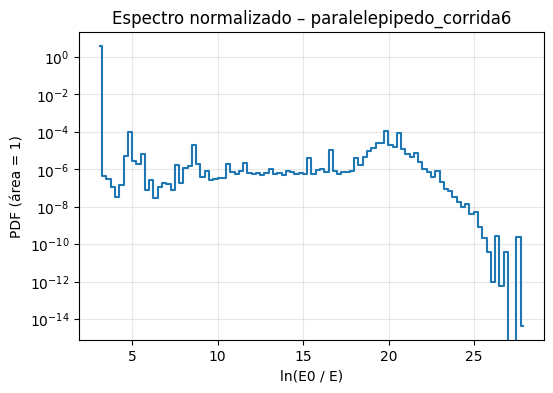

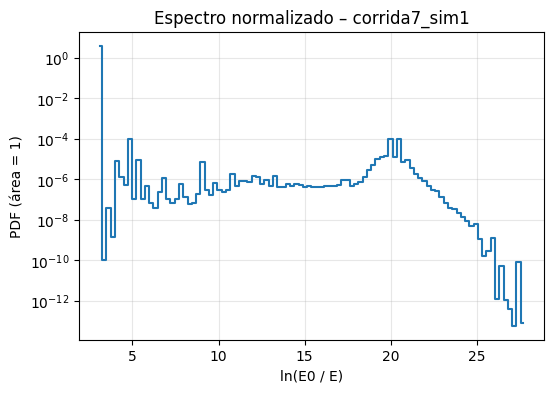

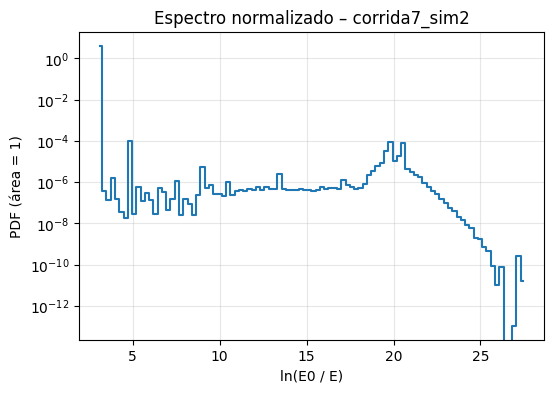

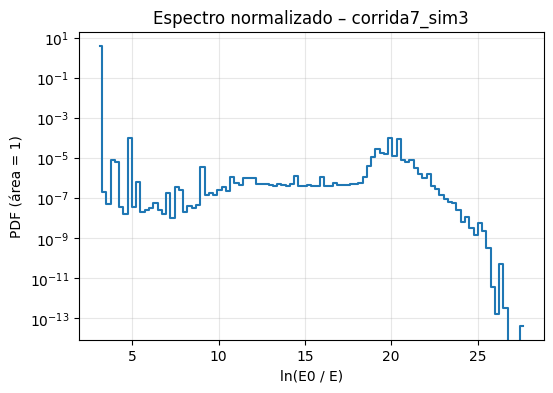

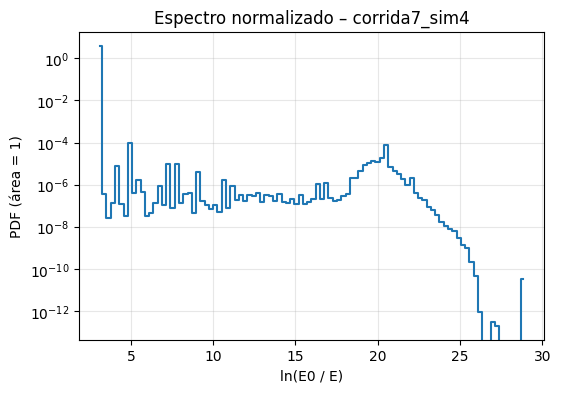

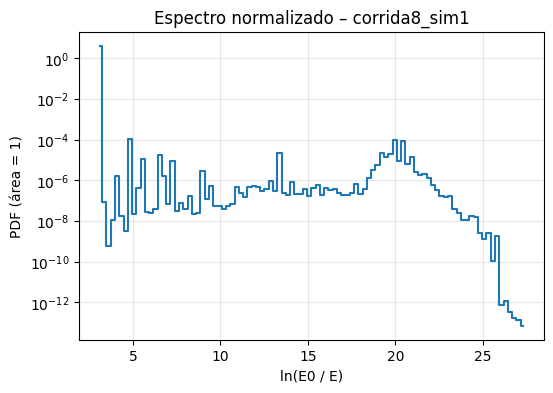

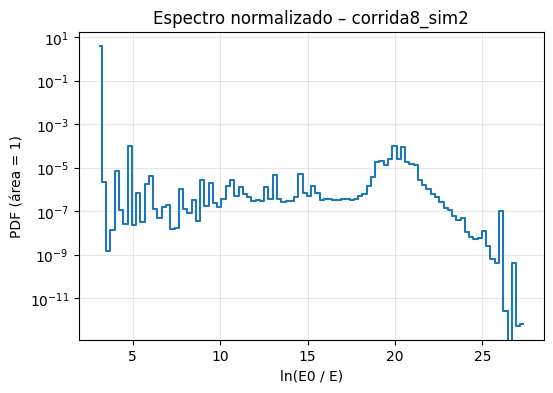

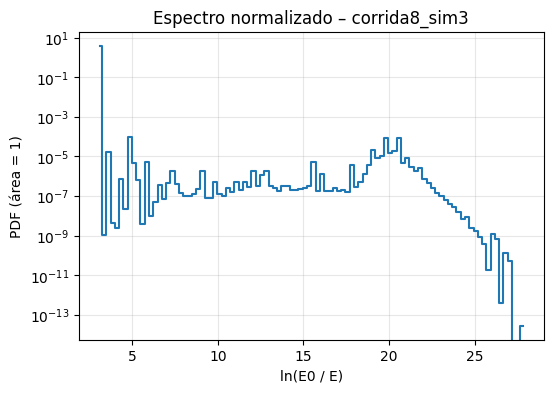

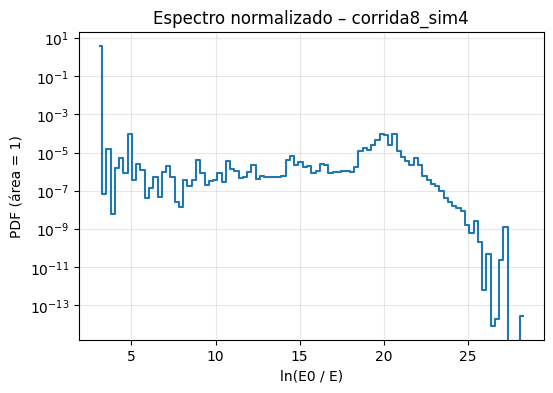

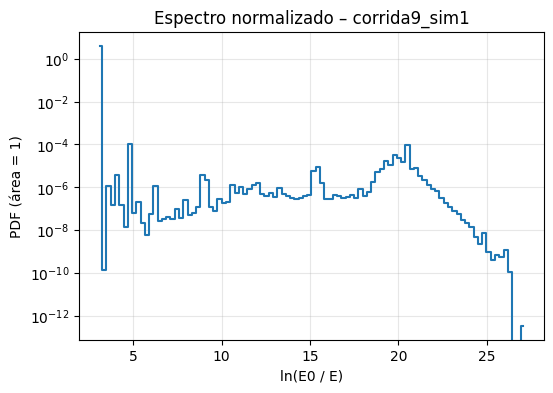

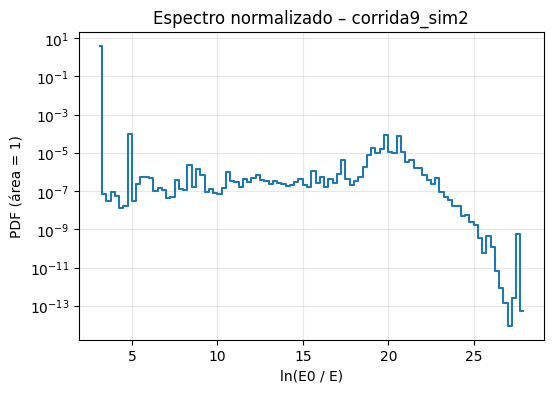

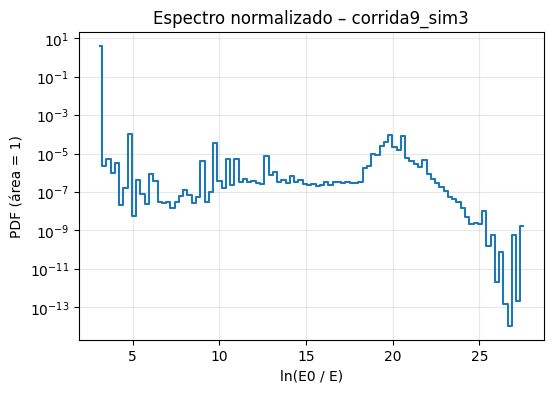

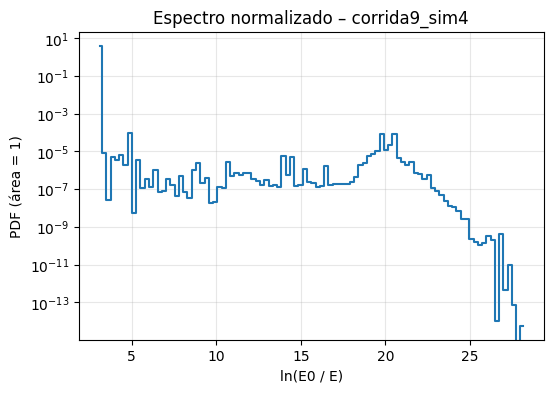

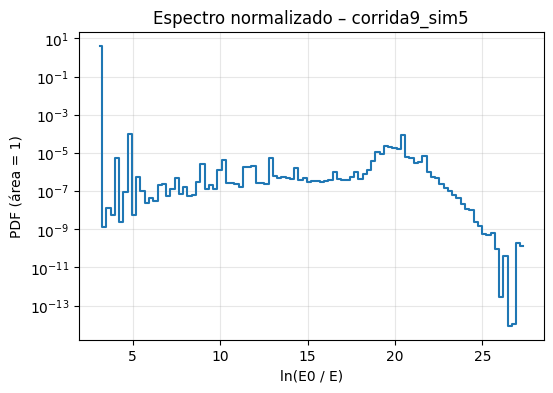

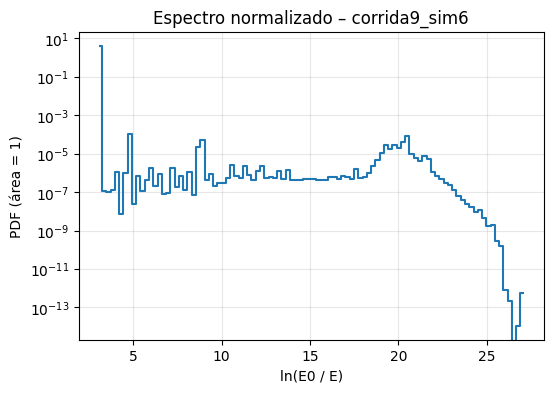

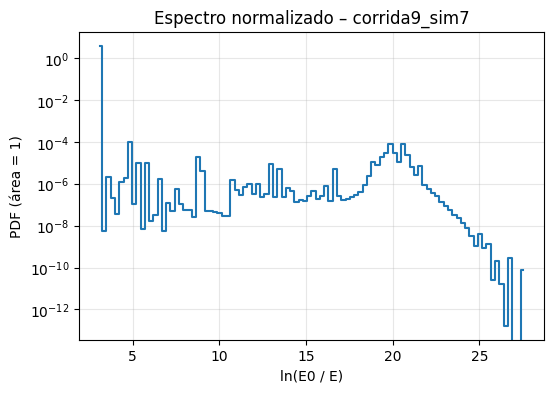

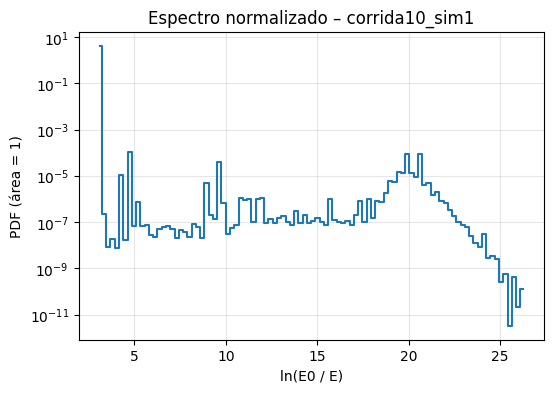

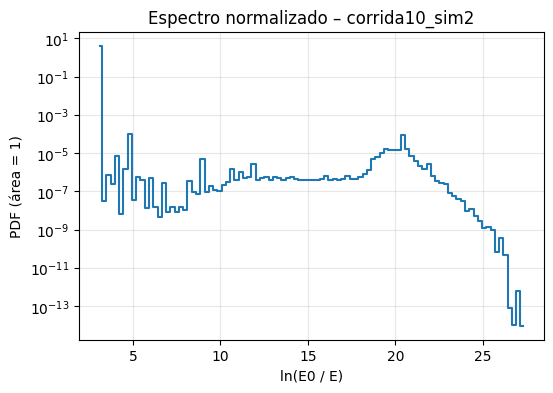

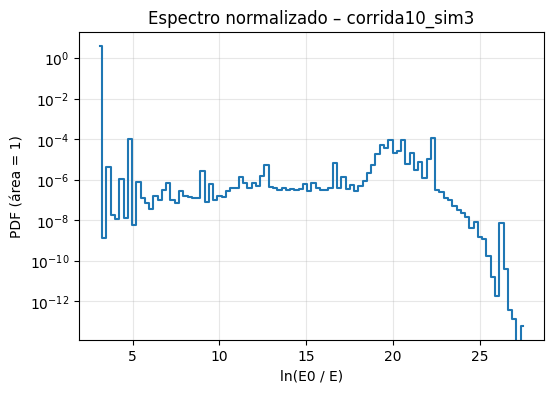

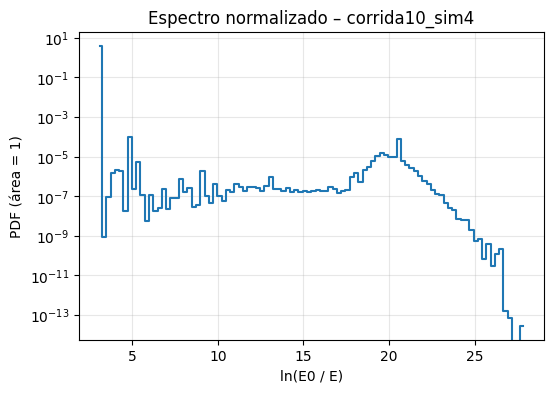

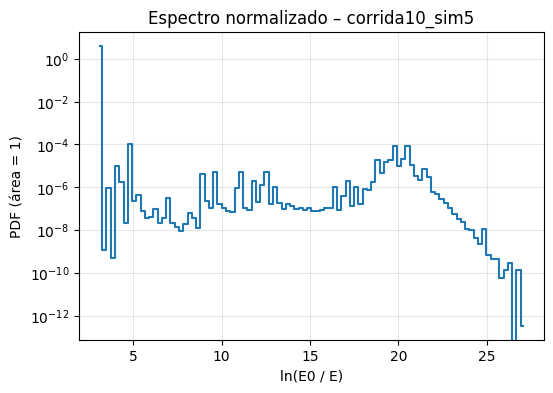

21 espectros procesados y guardados en 'plots_espectros/'.


In [ ]:
#!/usr/bin/env python3
"""
Rutinas para leer 'espectros.xml', normalizar cada espectro y graficarlo.

XML esperado (mismo formato que el generado antes):
<Simulations>
  <Simulation id="corrida7_sim3">
    ...
    <Spectrum scale="linear" bins="100">
      <BinEdges>e0,e1,e2,...</BinEdges>
      <WeightCounts>w0,w1,w2,...</WeightCounts>
    </Spectrum>
  </Simulation>
  ...
</Simulations>
"""

from __future__ import annotations

import xml.etree.ElementTree as ET
from dataclasses import dataclass
from pathlib import Path
from typing import List, Union

import matplotlib.pyplot as plt
import numpy as np


# -----------------------------------------------------------------------------
# Representación interna de un espectro
# -----------------------------------------------------------------------------
@dataclass
class Spectrum:
    """Contiene un único espectro ya convertido a arrays NumPy."""
    sim_id: str
    edges: np.ndarray   # shape (nbins + 1,)
    counts: np.ndarray  # shape (nbins,)

    def normalized_pdf(self) -> tuple[np.ndarray, np.ndarray]:
        """
        Devuelve (centros, alturas) del histograma normalizado a área 1.

        Altura = counts / (total_weight * bin_width)
        """
        bin_widths = np.diff(self.edges)
        total_weight = self.counts.sum()
        heights = self.counts / (total_weight * bin_widths)

        # Centros de bin para el gráfico
        centers = self.edges[:-1] + 0.5 * bin_widths
        return centers, heights


# -----------------------------------------------------------------------------
# Funciones públicas
# -----------------------------------------------------------------------------
def load_spectra(xml_path: Union[str, Path]) -> List[Spectrum]:
    """
    Lee 'xml_path' y devuelve una lista de Spectrum, tolerando BOM/espacios
    antes de la declaración XML.
    """
    xml_path = Path(xml_path).expanduser().resolve()

    # 1) Leer todo el texto, eliminando un posible BOM UTF-8 automáticamente
    with open(xml_path, "r", encoding="utf-8-sig") as f:
        xml_text = f.read()

    # 2) Quitar cualquier basura antes del primer '<'
    first_tag = xml_text.find("<")
    if first_tag > 0:
        xml_text = xml_text[first_tag:]

    # 3) Parsear desde la cadena limpia
    root = ET.fromstring(xml_text)

    spectra: List[Spectrum] = []
    for sim_el in root.iterfind("Simulation"):
        sim_id = sim_el.get("id", "unknown")

        spec_el = sim_el.find("Spectrum")
        if spec_el is None:
            continue

        edges_txt = spec_el.findtext("BinEdges")
        counts_txt = spec_el.findtext("WeightCounts")
        if edges_txt is None or counts_txt is None:
            continue

        edges = np.fromstring(edges_txt, sep=",", dtype=float)
        counts = np.fromstring(counts_txt, sep=",", dtype=float)
        spectra.append(Spectrum(sim_id, edges, counts))

    return spectra


def plot_spectra(
    spectra: List[Spectrum],
    output_dir: Union[str, Path] | None = None,
    show: bool = True,
) -> None:
    """
    Genera un gráfico por espectro y los guarda (opcionalmente).

    Parameters
    ----------
    spectra : list[Spectrum]
        Lista de espectros a graficar.
    output_dir : str | Path | None, default None
        Carpeta donde guardar PNGs.  Si es *None*, no se guardan archivos.
    show : bool, default True
        Llama a ``plt.show()`` al final si hay un entorno gráfico disponible.
    """
    if output_dir is not None:
        output_dir = Path(output_dir).expanduser()
        output_dir.mkdir(parents=True, exist_ok=True)

    for spec in spectra:
        centers, heights = spec.normalized_pdf()

        plt.figure(figsize=(6, 4))
        plt.step(centers, heights, where="mid")
        plt.xlabel("ln(E0 / E)")
        plt.ylabel("PDF (área = 1)")
        plt.title(f"Espectro normalizado – {spec.sim_id}")
        plt.grid(alpha=0.3)
        plt.yscale("log") 

        if output_dir is not None:
            fname = output_dir / f"{spec.sim_id}.png"
            plt.savefig(fname, dpi=150, bbox_inches="tight")

    if show:
        plt.show()


# -----------------------------------------------------------------------------
# Ejemplo de uso
# -----------------------------------------------------------------------------

XML_FILE = "espectros.xml"        # ← ajustá la ruta si hiciera falta
OUT_DIR = "plots_espectros"       # carpeta donde guardar las figuras

specs = load_spectra(XML_FILE)
plot_spectra(specs, output_dir=OUT_DIR)
print(f"{len(specs)} espectros procesados y guardados en '{OUT_DIR}/'.")


In [ ]:
with open("espectros.xml", "rb") as f:
    head = f.read(120)
print(repr(head))


b'<?xml version=\'1.0\' encoding=\'utf\xe2\x80\x918\'?>\n<Simulations>\n  <Simulation id="paralelepipedo_corrida6">\n    <ParticlesSimulat'


# Procesamiento de los trackfiles de distintos statepoints de una corrida

In [ ]:
"""Extract weighted energy spectra from multiple OpenMC surface_source.h5
files and consolidate them into a single XML, sharing a common binning.
"""

from __future__ import annotations
import os
from pathlib import Path
from typing import Union, List

import numpy as np
import xml.etree.ElementTree as ET

import kdsource.surfsource as kds

def extract_spectra(
    surf_paths: List[str],
    n_bins: int = 100,
    scale: str = "linear",
    xml_out: Union[str, Path] = "espectros.xml",
) -> Path:
    """
    Build a single XML containing one shared bin‐edge vector and, for each
    surface_source file, its weighted-count histogram.

    Parameters
    ----------
    surf_paths
        List of paths to surface_source files.
    n_bins
        Number of bins to use.
    scale
        "linear" ⇒ equal‐width in ln(E0/E); "log" ⇒ logarithmic spacing.
    xml_out
        Path to write the XML (overwritten if exists).

    Returns
    -------
    Path
        The XML file generated.
    """
    # --- validate
    if scale not in {"linear", "log"}:
        raise ValueError("`scale` must be 'linear' or 'log'.")

    xml_out = Path(xml_out).expanduser().resolve()
    xml_out.parent.mkdir(parents=True, exist_ok=True)

    # --- PASS 1: find global min/max of letargy
    global_min = np.inf
    global_max = -np.inf
    for fp in surf_paths:
        ssf = kds.SurfaceSourceFile(fp, domain={"w": [0, 2]})
        df = ssf.get_pandas_dataframe()
        letargy = df["ln(E0/E)"].to_numpy(dtype=np.float64, copy=False)
        global_min = min(global_min, letargy.min())
        global_max = max(global_max, letargy.max())

    # --- build common edges
    if scale == "linear":
        edges = np.linspace(global_min, global_max, n_bins + 1, dtype=np.float64)
    else:
        edges = np.logspace(global_min, global_max, n_bins + 1, dtype=np.float64)

    # --- XML root with single BinEdges
    root = ET.Element("Spectra", bins=str(n_bins), scale=scale)
    ET.SubElement(root, "BinEdges").text = _array_to_csv(edges)

    # --- PASS 2: histogram each file
    for fp in surf_paths:
        ssf = kds.SurfaceSourceFile(fp, domain={"w": [0, 2]})
        df = ssf.get_pandas_dataframe()
        letargy = df["ln(E0/E)"].to_numpy(dtype=np.float64, copy=False)
        weights = df["wgt"].to_numpy(dtype=np.float64, copy=False)
        counts, _ = np.histogram(letargy, bins=edges, weights=weights)

        hist_el = ET.SubElement(root, "Histogram", file=Path(fp).name)
        ET.SubElement(hist_el, "Counts").text = _array_to_csv(counts)

    # --- pretty‐print & write
    _indent_xml(root)
    tree = ET.ElementTree(root)
    tree.write(xml_out, encoding="utf-8", xml_declaration=True)

    return xml_out

def _array_to_csv(arr: np.ndarray) -> str:
    """Convert a NumPy array to a compact comma-separated string."""
    return ",".join(f"{v:.6e}" for v in arr)

def _indent_xml(elem: ET.Element, level: int = 0) -> None:
    """Recursively indent an XML *Element* for pretty printing."""
    indent = "  " * level
    if len(elem):
        if not elem.text or not elem.text.strip():
            elem.text = "\n" + indent + "  "
        for child in elem:
            _indent_xml(child, level + 1)
        if not child.tail or not child.tail.strip():
            child.tail = "\n" + indent
    if level and (not elem.tail or not elem.tail.strip()):
        elem.tail = "\n" + indent


Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida16/surface_source_100.h5: 26414
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida16/surface_source_200.h5: 2458549
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida16/surface_source_300.h5: 5002746
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida16/surface_source_400.h5: 1573445
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida16/surface_source_500.h5: 1030887
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida16/surface_source_700.h5: 3952673
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of particle

In [ ]:

surface_sources = []
for i in [100,200,300,400,500,700,1000,1200,1500,2500,3500,5000,7000,8000,9000,11000,14000]:
    surface_sources.append(f"/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida16/surface_source_{i}.h5")

xml_path = extract_spectra(
    surf_paths=surface_sources,
    n_bins=100,
    scale="linear",
    xml_out="espectros_corrida16.xml",
)
print(f"XML guardado en {xml_path}")

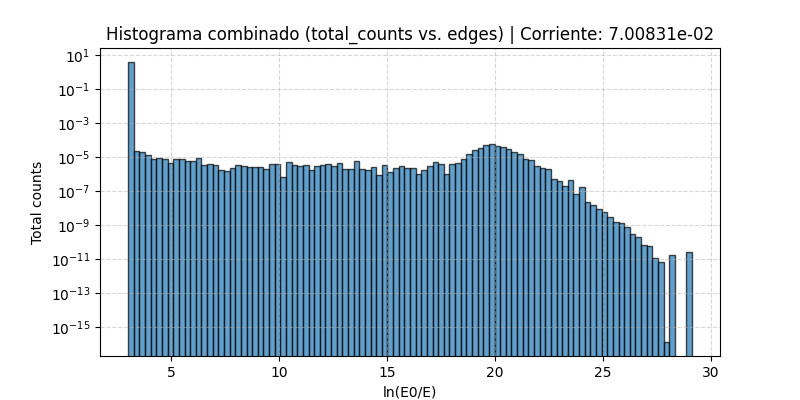

In [6]:
from pathlib import Path
from typing import Union, Tuple

import numpy as np
import xml.etree.ElementTree as ET


def load_merged_spectrum(xml_path: Union[str, Path]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Carga un XML con la estructura de <Spectra> y devuelve los vectores de
    bin-edges y de cuentas totales (suma de todos los <Counts>).

    Parameters
    ----------
    xml_path : str or Path
        Camino al archivo XML producido por `extract_spectra`.

    Returns
    -------
    edges : np.ndarray, shape (n_bins+1,)
        Vector de los valores de los límites de bin.
    total_counts : np.ndarray, shape (n_bins,)
        Vector de cuentas, suma de todos los histogramas.
    
    Raises
    ------
    ValueError
        Si falta el nodo <BinEdges> o algún <Counts>, o sus longitudes no coinciden.
    """
    # Garantizar objeto Path
    xml_path = Path(xml_path)
    # Parsear XML
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # 1) Extraer y parsear los bin edges
    edges_text = root.findtext("BinEdges")
    if edges_text is None:
        raise ValueError("No se encontró el elemento <BinEdges> en el XML.")
    # Convierte la cadena "v1,v2,..." en float array
    edges = np.fromstring(edges_text, sep=",")

    # Número de bins = len(edges) - 1
    n_counts = edges.size - 1
    # Inicializar el acumulador de counts
    total_counts = np.zeros(n_counts, dtype=float)

    # 2) Recorrer cada <Histogram> y sumar sus <Counts>
    for hist_el in root.findall("Histogram"):
        counts_text = hist_el.findtext("Counts")
        if counts_text is None:
            fname = hist_el.get("file", "<desconocido>")
            raise ValueError(f"No se encontró <Counts> en el histograma '{fname}'.")
        counts = np.fromstring(counts_text, sep=",")
        # Validar consistencia de longitudes
        if counts.size != n_counts:
            fname = hist_el.get("file", "<desconocido>")
            raise ValueError(
                f"El histograma '{fname}' tiene {counts.size} bins, "
                f"pero se esperaban {n_counts}."
            )
        total_counts += counts

    return edges, total_counts

edges, total_counts = load_merged_spectrum("espectros_corrida16.xml")

total_simulado = 8000 * 5000  # Total de partículas simuladas
corriente = total_counts.sum() / total_simulado  # Corriente total

import matplotlib.pyplot as plt

# Calcular el centro y ancho de cada bin
bin_centers = (edges[:-1] + edges[1:]) / 2
bin_widths = np.diff(edges)

# Normalizar el espectro para que el área bajo la curva sea 1
area = np.sum(total_counts * bin_widths)
total_counts = total_counts / area

plt.figure(figsize=(8, 4))
plt.bar(bin_centers, total_counts,
    width=bin_widths,
    align='center',
    edgecolor='k',
    alpha=0.7)
plt.xlabel('ln(E0/E)')
plt.ylabel('Total counts')
plt.title('Histograma combinado (total_counts vs. edges) | Corriente: {:.5e}'.format(corriente))
plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale('log')  # Escala logarítmica en el eje y
plt.show()